# Constraint Satisfaction Problem : Graph coloring


## Create Data

We can create a planar graph with $n$ vertices by randomly placing $n$ points in 2-dimensional Euclidean space and then performing a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).

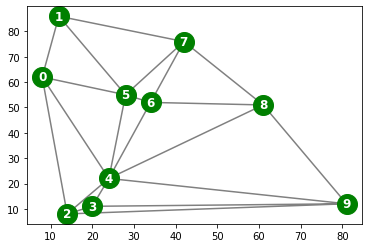

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

np.random.seed(1111)

# create points and sort them by 
n = 10
points = np.random.randint(100, size=(n, 2))
o = np.argsort(points[:,0])
points = points[o,:]


# triangulate
tri = Delaunay(points)


# plot
plt.triplot(points[:,0], points[:,1], tri.simplices, color = "gray")
plt.plot(points[:,0], points[:,1], 'o', color = "green", markersize = 20)

for i in range(len(points)):
       plt.annotate(i, points[i,:], 
        color='white', fontsize="large", weight='heavy',
        horizontalalignment='center', verticalalignment='center')

plt.show()

The triangulation can be converted into a list with an array of neighbor vertex indices for each point (see man page for [scipy.spatial.Delaunay](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html)). 

In [2]:
(indptr, indices) = tri.vertex_neighbor_vertices

neighbors = []

for k in range(len(indptr)-1):
    neighbors.append(np.sort(indices[indptr[k]:indptr[k+1]]))
    
neighbors

[array([1, 2, 4, 5], dtype=int32),
 array([0, 5, 7], dtype=int32),
 array([0, 3, 4, 9], dtype=int32),
 array([2, 4, 9], dtype=int32),
 array([0, 2, 3, 5, 6, 8, 9], dtype=int32),
 array([0, 1, 4, 6, 7], dtype=int32),
 array([4, 5, 7, 8], dtype=int32),
 array([1, 5, 6, 8], dtype=int32),
 array([4, 6, 7, 9], dtype=int32),
 array([2, 3, 4, 8], dtype=int32)]

The first row are the indices for the points neighboring point 0.

## Define CSP

The problem is defined as a dictionary with variable names, a dictionary with domain values for each variable and a set of binary  not-equal constraints (tuples of variables that are not allowed to have the same value).  

In [3]:
variables = [str(var) for var in range(n)]

domain = ['red', 'blue', 'green', 'orange']
#domain = ['red', 'blue', 'green']
domains = {}
for v in variables: 
    domains[v] = domain

# create binary constraints
constraints = {}
for i in range(len(neighbors)):
    for j in neighbors[i]:
        if(i<j): constraints[tuple([str(i), str(j)])] = True
constraints = constraints.keys()

csp = {'variables': variables, 'domains': domains, 'constraints': constraints, }
csp

{'variables': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'domains': {'0': ['red', 'blue', 'green', 'orange'],
  '1': ['red', 'blue', 'green', 'orange'],
  '2': ['red', 'blue', 'green', 'orange'],
  '3': ['red', 'blue', 'green', 'orange'],
  '4': ['red', 'blue', 'green', 'orange'],
  '5': ['red', 'blue', 'green', 'orange'],
  '6': ['red', 'blue', 'green', 'orange'],
  '7': ['red', 'blue', 'green', 'orange'],
  '8': ['red', 'blue', 'green', 'orange'],
  '9': ['red', 'blue', 'green', 'orange']},
 'constraints': dict_keys([('0', '1'), ('0', '2'), ('0', '4'), ('0', '5'), ('1', '5'), ('1', '7'), ('2', '3'), ('2', '4'), ('2', '9'), ('3', '4'), ('3', '9'), ('4', '5'), ('4', '6'), ('4', '8'), ('4', '9'), ('5', '6'), ('5', '7'), ('6', '7'), ('6', '8'), ('7', '8'), ('8', '9')])}

## Check Completeness and Consistency

`assignment` is a dictionary. Assigned variables have an entry with the variable name as the key. `{}` is therefore the empty assignment.

In [4]:
def complete(assignment, csp):
    return(all([v in assignment.keys() for v in csp['variables']])) 

print("complete({}, csp) =", complete({}, csp))

print("complete({...complete list...}, csp) =", 
      complete({'0': 'red', '1': 'red', '2': 'red', '3': 'red', '4': 'red', 
          '5': 'red', '6': 'red', '7': 'red', '8': 'red', '9': 'red'}, csp))

complete({}, csp) = False
complete({...complete list...}, csp) = True


In [5]:
def consistent(assignment, csp):
    for constr in csp['constraints']:
        if(constr[0] in assignment.keys() and constr[1] in assignment.keys()):
            if assignment[constr[0]] == assignment[constr[1]]: return(False)
        
    return(True)
        
print("consistent({}, csp) =", consistent({}, csp))
print("consistent({'0': 'red', '1': 'red', '2': 'blue'}, csp) =", 
      consistent({'0': 'red', '1': 'red', '2': 'blue'}, csp))

consistent({}, csp) = True
consistent({'0': 'red', '1': 'red', '2': 'blue'}, csp) = False


## Implement Simple Backtracking Search

In [6]:
# TODO: implement variable ordering. Choose variable with the minimum-remaining-values (MRV)
def select_unassigned_var(assignment, csp):
    if(complete(assignment, csp)): return(None)
    
    return(csp['variables'][np.where([not v in assignment.keys() for v in csp['variables']])[0][0]])

print("select_unassigned_var({'0': 'red', '1': 'blue'}, csp) =", 
     select_unassigned_var({'0': 'red', '1': 'blue'}, csp))

select_unassigned_var({'0': 'red', '1': 'blue'}, csp) = 2


In [7]:
# I use a global variable to turn on verbose mode in the recursion
#VERBOSE = True
VERBOSE = False
COUNT = 0

# returns None for failure
def backtrack_search(csp):
    global COUNT
    COUNT = 0
    
    assignment = backtrack({}, csp)
    
    print(f"Checked nodes: {COUNT}")
    
    return assignment

def backtrack(assignment, csp):
    global VERBOSE, COUNT
    
    COUNT += 1
    
    if complete(assignment, csp): 
        return assignment
    
    var = select_unassigned_var(assignment, csp)
    
    # TODO: implement value ordering. Use the least-constraining-vaue heuristic. 
    # for val in order_domain(assignment, var, csp)
    for val in csp['domains'][var]:
        assignment[var] = val
        
        if VERBOSE: print(f"Checking: {assignment}")
        
        if consistent(assignment, csp):
            
            #TODO: add inference for early failing (forward checking, )
            # if inference_fails(assignment, csp): return(None)
            result = backtrack(assignment, csp)
            if not result is None:
                    return(result)
                
        del assignment[var]
        
    if verbose: print(f"Backtracking")
    return(None) 

## Run Backtracking Search on the Random Problem

In [19]:
%timeit -n1 -r1 display(backtrack_search(csp))

Checked nodes: 11


{'0': 'red',
 '1': 'blue',
 '2': 'blue',
 '3': 'red',
 '4': 'green',
 '5': 'orange',
 '6': 'red',
 '7': 'green',
 '8': 'blue',
 '9': 'orange'}

9.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Plot the resulting coloring

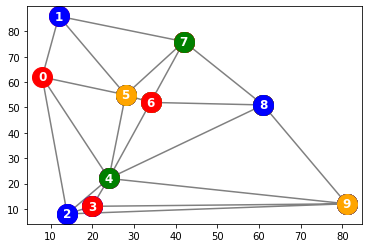

In [9]:
plt.triplot(points[:,0], points[:,1], tri.simplices, color = "gray")

for i in range(len(points)):
        plt.plot(points[i:,0], points[i:,1], 'o', color = list(res.values())[i], markersize = 20)
        plt.annotate(i, points[i,:], 
        color='white', fontsize="large", weight='heavy',
        horizontalalignment='center', verticalalignment='center')

plt.show()

## Assignment

Implement the following graph coloring algorithms:

* Add variable and value ordering to the implementation.
* Add forward checking to the implementation.
* Implement hill climbing local search with the min-conflicts heuristic.

Try to color graphs of several sizes with 3 and 4 colors. For each $n$, generate several random instances, and try to make n as large as you can manage. On average, how many constraints (edges) do your map coloring instances have for each $n$? Report the performance of each search algorithm as a function of $n$. For both variants of backtracking search, you can characterize performance in terms of the number of variable assignments attempted. For hill climbing search, report the number of uphill moves and random restarts required in order to reach a solution. Of course, you can also report raw running times as a function of $n$.